In [1]:
from math import sqrt

import fastai
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')
DPI = 120

In [2]:
game_info_data = pd.read_csv("src/data/game_info.csv")
train_data = pd.read_csv("src/data/user_data_train_no_comments.csv")
test_data = pd.read_csv("src/data/user_data_test_no_comments.csv")
valid_data = pd.read_csv("src/data/user_data_validation_no_comments.csv")

In [3]:
train_data

,Unnamed: 0,Userscore,Username,Game_ID
0,47246,9,SergeantSoz,119
1,199743,9,SergeantSoz,1540
2,235823,8,SergeantSoz,2227
3,263595,8,SergeantSoz,2941
4,72338,9,tomcrew10,238
...,...,...,...,...
105853,65974,10,Supersaiyan9000,198
105854,69938,10,Supersaiyan9000,218
105855,165164,10,Supersaiyan9000,1063
105856,231077,9,Supersaiyan9000,2137


In [4]:
#train_data["Userscore"].astype(float)

In [5]:
train_valid = pd.concat([train_data, valid_data])
print(len(train_data), len(valid_data), len(train_data)+ len(valid_data))
print(len(train_valid))
np.unique(train_data["Userscore"])

105858 14918 120776
120776


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [42]:
us_mean = train_valid["Userscore"].mean()
us_max = train_valid["Userscore"].max()
us_min = train_valid["Userscore"].min()

def format_data(data, normalize=True):
    """
    previously dropped columns and concatenated game id to platform
    now only drops `Unnamed: 0`
    """
    #cp = data.copy(deep=True)
    #cp["Title"] = cp["Title"] + " (" + cp["Platform"] + ")"
    #fmt = cp.drop(["Comment", "Platform", "Unnamed: 0"], axis=1)
    #us = fmt["Userscore"]
    fmt = data.drop(["Unnamed: 0"], axis=1)
    if normalize:
        fmt["Userscore"] = (fmt["Userscore"] - us_mean) / (us_max - us_min)
        #fmt["Userscore"] = fmt["Userscore"].astype(float)
        #pass
    return fmt

def group_data(data):
    """
    dict that maps username -> dataframe containing the user reviews
    """
    return dict(tuple(data.groupby('Username')))


#train_data_fmt = format_data(train_data)
#test_data_fmt = format_data(test_data, normalize=False)
#valid_data_fmt = format_data(valid_data)

train_data_fmt = format_data(train_data, normalize=False)
test_data_fmt = format_data(test_data, normalize=False)
valid_data_fmt = format_data(valid_data, normalize=False)

train_group = group_data(train_data_fmt)
test_group = group_data(test_data_fmt)
valid_group = group_data(valid_data_fmt)

In [43]:
#train_data_fmt["Userscore"] * (us_max - us_min) + us_mean
train_data_fmt

,Userscore,Username,Game_ID
0,9,SergeantSoz,119
1,9,SergeantSoz,1540
2,8,SergeantSoz,2227
3,8,SergeantSoz,2941
4,9,tomcrew10,238
...,...,...,...
105853,10,Supersaiyan9000,198
105854,10,Supersaiyan9000,218
105855,10,Supersaiyan9000,1063
105856,9,Supersaiyan9000,2137


In [44]:
def restrict_data(data, restrict):
    """
    gives the dataset where (# of reviews for a user) >= restrict
    """
    dfs = group_data(data)
    pop_keys = []
    for k in dfs:
        if len(dfs[k]) < restrict:
            pop_keys.append(k)
            
    for k in pop_keys:
        #print(k)
        dfs.pop(k)
    
    return pd.concat(dfs.values(), ignore_index=True)
    #for k in dfs:
    #    if new_df is None:
    #        new_df = dfs[k]
    #    else:
    #        new_df.append(dfs[k])
    
    #return new_df
   

(array([ 4538.,  1774.,  1691.,  2199.,  2795.,  4011.,  5295.,  8130.,
        14494., 23038., 37893.]),
 array([ 0.        ,  0.90909091,  1.81818182,  2.72727273,  3.63636364,
         4.54545455,  5.45454545,  6.36363636,  7.27272727,  8.18181818,
         9.09090909, 10.        ]),
 <BarContainer object of 11 artists>)

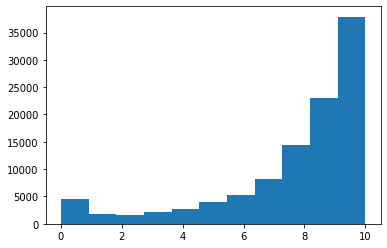

In [45]:
plt.hist(train_data['Userscore'], bins=11)

(array([ 4538.,  1774.,  1691.,  2199.,  2795.,  4011.,  5295.,  8130.,
        14494., 23038., 37893.]),
 array([ 0.        ,  0.90909091,  1.81818182,  2.72727273,  3.63636364,
         4.54545455,  5.45454545,  6.36363636,  7.27272727,  8.18181818,
         9.09090909, 10.        ]),
 <BarContainer object of 11 artists>)

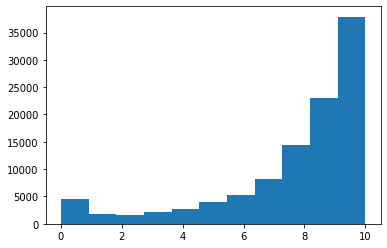

In [46]:
plt.hist(train_data_fmt['Userscore'], bins=11)

In [47]:
print(len(train_data_fmt))
print(len(test_data_fmt))

105858
31221


In [48]:
np.unique(train_data_fmt["Userscore"])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [49]:
# base rmse
# RMSE = \sqrt(MSE)
# MSE = (1/n) * \sum (Y_pred - Y_expected)^2
def get_base_rmse():
    # y_pred = expected value of the train score
    y_pred = train_data['Userscore'].mean()
    n = len(test_reviews_group)
    
    scores_squared_sum = 0
    for user in test_reviews_group:
        # y_expected probably incorrect: select .iloc[0]?
        #y_expected = test_reviews_group[user]["Userscore"].iloc[0]
        y_expected = test_reviews_group[user]["Userscore"].mean()
        scores_squared_sum += (y_pred - y_expected)**2
        
    return sqrt(scores_squared_sum / n)
        
    #expected_val_score
    
def get_base_rmse2(train, test):
    y_pred = train['Userscore'].mean()
    rep = np.repeat(y_pred, len(test['Userscore']))
    return mean_squared_error(test['Userscore'], rep, squared=False)

get_base_rmse2(train_data, test_data)
#get_base_rmse2(train_data_fmt_3, test_data_fmt_3)

2.7464267971419734

# ML stuff here

In [50]:
from fastai.tabular.all import *
from fastai.collab import *
#from fastai.learner import *
#from fastai.column_data import *

In [66]:
user_name_var = "Username"
rating_name_var = "Userscore"
item_name_var = "Game_ID"
batch_size = 64 # hyperparam?
valid_pct=0 # sets validation set to 0 lmao
seed = 69

dls = CollabDataLoaders.from_df(train_data_fmt,
                                user_name=user_name_var,
                                rating_name=rating_name_var,
                                item_name=item_name_var,
                                valid_pct=valid_pct,
                                bs=batch_size,
                                seed=seed
                               )

dls_train = CollabDataLoaders.from_df(train_data_fmt,
                                user_name=user_name_var,
                                rating_name=rating_name_var,
                                item_name=item_name_var,
                                valid_pct=valid_pct,
                                bs=batch_size,
                                seed=seed
                               )

# what if instead of using 10% of the brain, we used 0% of the brain?
# hack to set the validation set of dls to whatever dataset we want
dls_test = CollabDataLoaders.from_df(test_data_fmt,
                                user_name=user_name_var,
                                rating_name=rating_name_var,
                                item_name=item_name_var,
                                valid_pct=valid_pct,
                                bs=batch_size,
                                seed=seed
                               )

dls_valid = CollabDataLoaders.from_df(valid_data_fmt,
                                user_name=user_name_var,
                                rating_name=rating_name_var,
                                item_name=item_name_var,
                                valid_pct=valid_pct,
                                bs=batch_size,
                                seed=seed
                               )

def get_sample_rmse(dl_trained, dl_test, learner, denormalize=True, round_to_int=True):
    dl_trained.valid = dl_test.train
    preds, targs = learner.get_preds() # predictions, expected
    
    #print(preds)
    
    if denormalize:
        preds = preds * (us_max - us_min) + us_mean
        #print(preds)
    
    if round_to_int:
        preds = np.rint(preds)
        #print(preds)
        
    #print(np.unique(preds))
    #print(len(np.unique(preds)))
   
    return mean_squared_error(preds, np.ravel(targs), squared=False)
        
    #if denormalize:
    #    #preds_denormalized = preds * (us_max - us_min) + us_mean
    #    # np.rint rounds to nearest integer for most accurate predictions
    #    print(len(np.unique(preds * (us_max - us_min) + us_mean)))
    #    preds_denormalized = np.rint(preds * (us_max - us_min) + us_mean)
    #    return mean_squared_error(preds_denormalized, np.ravel(targs), squared=False)
    #else: # normal
    #    print(len(np.unique(preds)))
    #    return mean_squared_error(preds, np.ravel(targs), squared=False)

    #print(preds_denormalized)
    #print(targs)
    #print(rmse)

In [97]:
# hyperparams?
weight_decay = 0.1 # https://towardsdatascience.com/this-thing-called-weight-decay-a7cd4bcfccab
learning_rate = 5e-3
#n_factors = 50
#epoch_n = 5

n_factors = 4
epoch_n = 8

#weight_decay = 0.1
#learning_rate = 1e-5
#epoch_n = 7
#learning_rate = 5e-2
#learning_rate = 0.1
#learning_rate = 1e-5

y_range = np.min(train_data_fmt["Userscore"]), np.max(train_data_fmt["Userscore"])
print(y_range)

dls.valid = dls_valid.train

# use_nn = False to use embedded matrices (EmbeddingDotBias)
#learn = collab_learner(dls, n_factors=n_factors, y_range=(0, 10), use_nn=False)
learn = collab_learner(dls, n_factors=n_factors, y_range=y_range, use_nn=False)
#learn = collab_learner(dls, n_factors=n_factors, use_nn=False)

(0, 10)


In [98]:
#learn.fit_one_cycle(5, 5e-3, wd=0.1)
learn.fit_one_cycle(epoch_n, learning_rate, wd=weight_decay)
#learn.fit_one_cycle(10, 10e-4, wd=0.1)

epoch,train_loss,valid_loss,time
0,10.965042,12.837894,00:07
1,6.661634,9.996500,00:07
2,5.956037,9.422836,00:07
3,5.620092,9.301481,00:07
4,5.311704,9.284326,00:07
5,5.102957,9.263831,00:08
6,5.092161,9.254695,00:07
7,4.875652,9.256540,00:08


In [91]:
get_sample_rmse(dls, dls_test, learn, denormalize=False, round_to_int=False)

3.1977031

In [82]:
print(dls_test.train_ds)

       Userscore  Username  Game_ID
31057          9      2875      304
18536          7      1994     2645
26138         10      2313      571
11092         10      2286       52
7153           5      3761      425
...          ...       ...      ...
29569          9      4006      214
21965          6      1206      480
18261          8      2695      955
21257          9      1858     2389
3897           8      1830     1280

[31221 rows x 3 columns]


In [92]:
def select_hyperparams(n_factors_list, max_epoch_n):
    #print("{nf}: {rmse}")
    results = {}
    for nf in n_factors_list:
        # initializes new instance to reset seed I think
        dls_temp = CollabDataLoaders.from_df(train_data_fmt,
                                        user_name=user_name_var,
                                        rating_name=rating_name_var,
                                        item_name=item_name_var,
                                        valid_pct=valid_pct,
                                        bs=batch_size,
                                        seed=seed
                                        #procs=[Normalize]
                                       )
        # reset dls.train and dls.valid to train / validation sets respectively
        #dls_temp.train = dls_train.train
        # sets the validation set properly
        dls_temp.valid = dls_valid.train

        #learn_temp = collab_learner(dls_temp, n_factors=nf, y_range=(0, 10), use_nn=False)
        learn_temp = collab_learner(dls_temp, n_factors=nf, y_range=y_range, use_nn=False)
        
        for _ep_n in range(max_epoch_n):
            ep_n = _ep_n + 1

            learn_temp.fit_one_cycle(1, learning_rate, wd=weight_decay)

            #preds, targs = learn_temp.get_preds()
            #rmse = mean_squared_error(preds.numpy(), np.ravel(targs.numpy()), squared=False)
            rmse = get_sample_rmse(dls_temp, dls_valid, learn_temp, denormalize=False, round_to_int=False)
            print(f"({nf}, {ep_n}): {rmse}")
            results[(nf, ep_n)] = rmse
        
    return results

In [93]:
#n_factors_list = list(range(5, 105, 5))
n_factors_list = [3, 4, 5, 8, 10, 15, 20, 30, 40, 50, 60, 70]
#print(len(n_factors_list), n_factors_list)

In [94]:
map_nf_rmse = select_hyperparams(n_factors_list, 8)

epoch,train_loss,valid_loss,time
0,8.613183,11.299406,00:07


(3, 1): 3.3614137172698975


epoch,train_loss,valid_loss,time
0,6.893246,10.109844,00:07


(3, 2): 3.1796281337738037


epoch,train_loss,valid_loss,time
0,6.131683,9.654662,00:07


(3, 3): 3.107067823410034


epoch,train_loss,valid_loss,time
0,5.755854,9.486017,00:07


(3, 4): 3.079742670059204


epoch,train_loss,valid_loss,time
0,5.714503,9.381143,00:07


(3, 5): 3.0625362396240234


epoch,train_loss,valid_loss,time
0,5.594379,9.329872,00:07


(3, 6): 3.0551083087921143


epoch,train_loss,valid_loss,time
0,5.587293,9.307115,00:07


(3, 7): 3.0509610176086426


epoch,train_loss,valid_loss,time
0,5.498016,9.302826,00:07


(3, 8): 3.05026912689209


epoch,train_loss,valid_loss,time
0,8.359947,11.221835,00:07


(4, 1): 3.350184917449951


epoch,train_loss,valid_loss,time
0,6.887998,10.009400,00:07


(4, 2): 3.1637587547302246


epoch,train_loss,valid_loss,time
0,6.029792,9.615848,00:07


(4, 3): 3.1011884212493896


epoch,train_loss,valid_loss,time
0,5.749023,9.477569,00:07


(4, 4): 3.0779807567596436


epoch,train_loss,valid_loss,time
0,5.602070,9.381258,00:07


(4, 5): 3.0624470710754395


epoch,train_loss,valid_loss,time
0,5.382803,9.301937,00:07


(4, 6): 3.0501151084899902


epoch,train_loss,valid_loss,time
0,5.514366,9.267034,00:07


(4, 7): 3.04417085647583


epoch,train_loss,valid_loss,time
0,5.308408,9.262889,00:07


(4, 8): 3.043945550918579


epoch,train_loss,valid_loss,time
0,8.503384,11.249972,00:07


(5, 1): 3.35416579246521


epoch,train_loss,valid_loss,time
0,6.696906,10.095446,00:07


(5, 2): 3.1772122383117676


epoch,train_loss,valid_loss,time
0,5.946614,9.674823,00:07


(5, 3): 3.1106348037719727


epoch,train_loss,valid_loss,time
0,5.540737,9.518631,00:07


(5, 4): 3.0851759910583496


epoch,train_loss,valid_loss,time
0,5.601711,9.381444,00:07


(5, 5): 3.0630342960357666


epoch,train_loss,valid_loss,time
0,5.483553,9.339892,00:07


(5, 6): 3.0564138889312744


epoch,train_loss,valid_loss,time
0,4.979487,9.323096,00:07


(5, 7): 3.0535645484924316


epoch,train_loss,valid_loss,time
0,5.008620,9.284156,00:07


(5, 8): 3.046691656112671


epoch,train_loss,valid_loss,time
0,8.414125,11.251845,00:07


(8, 1): 3.3543450832366943


epoch,train_loss,valid_loss,time
0,6.467555,10.103229,00:07


(8, 2): 3.178215742111206


epoch,train_loss,valid_loss,time
0,5.770679,9.689746,00:07


(8, 3): 3.112788438796997


epoch,train_loss,valid_loss,time
0,5.486622,9.475536,00:07


(8, 4): 3.0783979892730713


epoch,train_loss,valid_loss,time
0,5.274868,9.395760,00:07


(8, 5): 3.065267562866211


epoch,train_loss,valid_loss,time
0,4.859616,9.359983,00:07


(8, 6): 3.0594098567962646


epoch,train_loss,valid_loss,time
0,4.678821,9.356577,00:07


(8, 7): 3.0586795806884766


epoch,train_loss,valid_loss,time
0,4.844494,9.341671,00:07


(8, 8): 3.0566635131835938


epoch,train_loss,valid_loss,time
0,8.476717,11.197233,00:07


(10, 1): 3.346421003341675


epoch,train_loss,valid_loss,time
0,6.541567,10.051790,00:07


(10, 2): 3.17036509513855


epoch,train_loss,valid_loss,time
0,5.622823,9.667965,00:07


(10, 3): 3.109553575515747


epoch,train_loss,valid_loss,time
0,5.141603,9.501186,00:07


(10, 4): 3.082207679748535


epoch,train_loss,valid_loss,time
0,4.990722,9.431671,00:07


(10, 5): 3.0721774101257324


epoch,train_loss,valid_loss,time
0,5.076582,9.403281,00:07


(10, 6): 3.0662457942962646


epoch,train_loss,valid_loss,time
0,4.994081,9.361672,00:07


(10, 7): 3.059577226638794


epoch,train_loss,valid_loss,time
0,4.851108,9.349506,00:07


(10, 8): 3.0572774410247803


epoch,train_loss,valid_loss,time
0,8.168576,11.162755,00:07


(15, 1): 3.341489791870117


epoch,train_loss,valid_loss,time
0,6.549704,9.946314,00:07


(15, 2): 3.1539108753204346


epoch,train_loss,valid_loss,time
0,5.346024,9.558337,00:07


(15, 3): 3.091644763946533


epoch,train_loss,valid_loss,time
0,4.912823,9.411076,00:07


(15, 4): 3.0676214694976807


epoch,train_loss,valid_loss,time
0,4.716810,9.341352,00:07


(15, 5): 3.0561184883117676


epoch,train_loss,valid_loss,time
0,4.513677,9.320388,00:07


(15, 6): 3.0535035133361816


epoch,train_loss,valid_loss,time
0,4.419250,9.300238,00:07


(15, 7): 3.0496926307678223


epoch,train_loss,valid_loss,time
0,4.373082,9.316895,00:07


(15, 8): 3.052072286605835


epoch,train_loss,valid_loss,time
0,7.998365,11.166525,00:07


(20, 1): 3.3418378829956055


epoch,train_loss,valid_loss,time
0,6.018353,9.979086,00:07


(20, 2): 3.158714532852173


epoch,train_loss,valid_loss,time
0,5.323132,9.571515,00:07


(20, 3): 3.093562126159668


epoch,train_loss,valid_loss,time
0,4.888800,9.434449,00:07


(20, 4): 3.0714855194091797


epoch,train_loss,valid_loss,time
0,4.426384,9.339815,00:07


(20, 5): 3.0560050010681152


epoch,train_loss,valid_loss,time
0,4.363253,9.380463,00:07


(20, 6): 3.06233286857605


epoch,train_loss,valid_loss,time
0,4.057150,9.367211,00:07


(20, 7): 3.0610198974609375


epoch,train_loss,valid_loss,time
0,4.034358,9.409785,00:07


(20, 8): 3.068028450012207


epoch,train_loss,valid_loss,time
0,8.036018,11.109079,00:07


(30, 1): 3.3327529430389404


epoch,train_loss,valid_loss,time
0,5.802064,9.840036,00:07


(30, 2): 3.1371877193450928


epoch,train_loss,valid_loss,time
0,4.917459,9.493984,00:07


(30, 3): 3.0812788009643555


epoch,train_loss,valid_loss,time
0,4.316163,9.382085,00:07


(30, 4): 3.063002586364746


epoch,train_loss,valid_loss,time
0,4.303764,9.434155,00:07


(30, 5): 3.0712599754333496


epoch,train_loss,valid_loss,time
0,3.721310,9.368457,00:07


(30, 6): 3.060485601425171


epoch,train_loss,valid_loss,time
0,3.576934,9.339959,00:07


(30, 7): 3.056077718734741


epoch,train_loss,valid_loss,time
0,3.527159,9.344376,00:07


(30, 8): 3.056769847869873


epoch,train_loss,valid_loss,time
0,7.597480,10.998896,00:07


(40, 1): 3.316459894180298


epoch,train_loss,valid_loss,time
0,5.630638,9.730438,00:07


(40, 2): 3.1195363998413086


epoch,train_loss,valid_loss,time
0,4.825264,9.380738,00:07


(40, 3): 3.062894105911255


epoch,train_loss,valid_loss,time
0,4.077387,9.319356,00:07


(40, 4): 3.05279541015625


epoch,train_loss,valid_loss,time
0,3.661644,9.320178,00:07


(40, 5): 3.0527777671813965


epoch,train_loss,valid_loss,time
0,3.523522,9.403942,00:07


(40, 6): 3.066749334335327


epoch,train_loss,valid_loss,time
0,3.267601,9.417680,00:07


(40, 7): 3.0689210891723633


epoch,train_loss,valid_loss,time
0,3.159122,9.405889,00:07


(40, 8): 3.0665030479431152


epoch,train_loss,valid_loss,time
0,7.642199,10.969601,00:07


(50, 1): 3.3121163845062256


epoch,train_loss,valid_loss,time
0,5.453791,9.791038,00:07


(50, 2): 3.128972291946411


epoch,train_loss,valid_loss,time
0,4.422443,9.479143,00:07


(50, 3): 3.0786473751068115


epoch,train_loss,valid_loss,time
0,3.957232,9.473887,00:07


(50, 4): 3.077742576599121


epoch,train_loss,valid_loss,time
0,3.515582,9.453664,00:07


(50, 5): 3.074617624282837


epoch,train_loss,valid_loss,time
0,3.170885,9.393737,00:07


(50, 6): 3.0652835369110107


epoch,train_loss,valid_loss,time
0,3.007710,9.376923,00:07


(50, 7): 3.062129259109497


epoch,train_loss,valid_loss,time
0,2.872657,9.397702,00:07


(50, 8): 3.0658605098724365


epoch,train_loss,valid_loss,time
0,7.511948,10.961658,00:07


(60, 1): 3.3111720085144043


epoch,train_loss,valid_loss,time
0,5.254797,9.825957,00:07


(60, 2): 3.134671211242676


epoch,train_loss,valid_loss,time
0,4.308416,9.516952,00:07


(60, 3): 3.085299015045166


epoch,train_loss,valid_loss,time
0,3.725758,9.450719,00:07


(60, 4): 3.074500322341919


epoch,train_loss,valid_loss,time
0,3.261154,9.427587,00:07


(60, 5): 3.0703647136688232


epoch,train_loss,valid_loss,time
0,2.845326,9.393519,00:07


(60, 6): 3.0645527839660645


epoch,train_loss,valid_loss,time
0,2.780103,9.490278,00:07


(60, 7): 3.080791711807251


epoch,train_loss,valid_loss,time
0,2.617254,9.368851,00:07


(60, 8): 3.0604140758514404


epoch,train_loss,valid_loss,time
0,7.647712,10.910271,00:07


(70, 1): 3.3028805255889893


epoch,train_loss,valid_loss,time
0,5.313463,9.814484,00:07


(70, 2): 3.1333625316619873


epoch,train_loss,valid_loss,time
0,4.149459,9.575229,00:07


(70, 3): 3.0944557189941406


epoch,train_loss,valid_loss,time
0,3.468315,9.478295,00:07


(70, 4): 3.0787978172302246


epoch,train_loss,valid_loss,time
0,3.116683,9.578549,00:07


(70, 5): 3.094512939453125


epoch,train_loss,valid_loss,time
0,2.748307,9.442397,00:07


(70, 6): 3.0734975337982178


epoch,train_loss,valid_loss,time
0,2.512094,9.462255,00:07


(70, 7): 3.0756454467773438


epoch,train_loss,valid_loss,time
0,2.332652,9.428006,00:07


(70, 8): 3.0702075958251953


In [95]:
map_nf_rmse

{(3, 1): 3.3614137,
 (3, 2): 3.1796281,
 (3, 3): 3.1070678,
 (3, 4): 3.0797427,
 (3, 5): 3.0625362,
 (3, 6): 3.0551083,
 (3, 7): 3.050961,
 (3, 8): 3.0502691,
 (4, 1): 3.350185,
 (4, 2): 3.1637588,
 (4, 3): 3.1011884,
 (4, 4): 3.0779808,
 (4, 5): 3.062447,
 (4, 6): 3.050115,
 (4, 7): 3.0441709,
 (4, 8): 3.0439456,
 (5, 1): 3.3541658,
 (5, 2): 3.1772122,
 (5, 3): 3.1106348,
 (5, 4): 3.085176,
 (5, 5): 3.0630343,
 (5, 6): 3.056414,
 (5, 7): 3.0535645,
 (5, 8): 3.0466917,
 (8, 1): 3.354345,
 (8, 2): 3.1782157,
 (8, 3): 3.1127884,
 (8, 4): 3.078398,
 (8, 5): 3.0652676,
 (8, 6): 3.0594099,
 (8, 7): 3.0586796,
 (8, 8): 3.0566635,
 (10, 1): 3.346421,
 (10, 2): 3.170365,
 (10, 3): 3.1095536,
 (10, 4): 3.0822077,
 (10, 5): 3.0721774,
 (10, 6): 3.0662458,
 (10, 7): 3.0595772,
 (10, 8): 3.0572774,
 (15, 1): 3.3414898,
 (15, 2): 3.1539109,
 (15, 3): 3.0916448,
 (15, 4): 3.0676215,
 (15, 5): 3.0561185,
 (15, 6): 3.0535035,
 (15, 7): 3.0496926,
 (15, 8): 3.0520723,
 (20, 1): 3.341838,
 (20, 2): 3.15

In [96]:
sorted(tuple(map_nf_rmse.items()), key=lambda x: x[1])

[((4, 8), 3.0439456),
 ((4, 7), 3.0441709),
 ((5, 8), 3.0466917),
 ((15, 7), 3.0496926),
 ((4, 6), 3.050115),
 ((3, 8), 3.0502691),
 ((3, 7), 3.050961),
 ((15, 8), 3.0520723),
 ((40, 5), 3.0527778),
 ((40, 4), 3.0527954),
 ((15, 6), 3.0535035),
 ((5, 7), 3.0535645),
 ((3, 6), 3.0551083),
 ((20, 5), 3.056005),
 ((30, 7), 3.0560777),
 ((15, 5), 3.0561185),
 ((5, 6), 3.056414),
 ((8, 8), 3.0566635),
 ((30, 8), 3.0567698),
 ((10, 8), 3.0572774),
 ((8, 7), 3.0586796),
 ((8, 6), 3.0594099),
 ((10, 7), 3.0595772),
 ((60, 8), 3.060414),
 ((30, 6), 3.0604856),
 ((20, 7), 3.06102),
 ((50, 7), 3.0621293),
 ((20, 6), 3.0623329),
 ((4, 5), 3.062447),
 ((3, 5), 3.0625362),
 ((40, 3), 3.062894),
 ((30, 4), 3.0630026),
 ((5, 5), 3.0630343),
 ((60, 6), 3.0645528),
 ((8, 5), 3.0652676),
 ((50, 6), 3.0652835),
 ((50, 8), 3.0658605),
 ((10, 6), 3.0662458),
 ((40, 8), 3.066503),
 ((40, 6), 3.0667493),
 ((15, 4), 3.0676215),
 ((20, 8), 3.0680285),
 ((40, 7), 3.068921),
 ((70, 8), 3.0702076),
 ((60, 5), 3.07

In [ ]:
get_sample_rmse(dls, dls_test, learn, denormalize=False, round_to_int=False)